## Exploratory data analysis: PCA and Mahalanobis distance analysis

**Author:** Y.X. Wu

This notebook aims to conduct a comparative analysis between our new data set and existing literature data set based on two properties: hardness and corrosion. Both data sets have a defined compositional feature space. The new data set, however, is generated in a different regime of the compositional feature space.

The purpose of the analysis is twofold:

- **Principal Component Analysis (PCA)**: We'll use PCA as a technique to reduce the dimensionality of the feature space. It will allow us to effectively visualize the new data alongside the literature data within the same reduced feature space. PCA does this by transforming the original variables into a new set of uncorrelated variables called principal components, which are ordered by the amount of variance they can explain from the original data. This allows us to capture most of the information in the original data with fewer dimensions.

- **Mahalanobis Distance Calculation**: Following the visualization, we'll take a more in-depth look into the data by calculating the Mahalanobis distance for all the new data points from the centroid of the literature data set. The Mahalanobis distance is a measure of the distance between a point and a distribution, not between two distinct points. It's effectively a multivariate equivalent of the Euclidean distance. However, unlike Euclidean distance, the Mahalanobis distance is scale-invariant and takes into account the correlations of the data set. By calculating the Mahalanobis distance, we can quantify how much the new data deviates from the distribution of the literature data.


In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math 
import matplotlib.cm as cm
import matplotlib as mpl
import os

# display the current working directory
display("Current working directory: {0}".format(os.getcwd()))

data_path = '../Dataset_Cleaned/'
display(os.path.isfile(data_path+'LiteratureDataset_Hardness_YW_v3_processed.xlsx'))

'Current working directory: /nethome/home3/yuxiang.wu/CCA-representation-ML/Dataset_EDA_Pairplot_Feature_PCA_Mahalanobis'

True

### Import hardness and corrosion LITERATURE datasets


In [23]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm', 'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets 
df_H = pd.read_excel(data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_features, df_H_output  = df_H[compo_column], df_H[specific_features_sel_column], df_H[H_output_column]
(df_C_compo, df_C_specific_testing, 
 df_C_specific_features, df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat([df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat([df_C_compo, df_C_specific_features], axis=1)
 

### Import NEW dataset


In [24]:
# Specify columns for NiCrCoVFe and NiCrMoTiFe composition dataframes
NiCrCoVFe_compo_column = ['Ni', 'Cr', 'Co', 'V', 'Fe']
NiCrMoTiFe_compo_column = ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']

# Load NiCrCoVFe and NiCrMoTiFe datasets
df_NiCrCoVFe  = pd.read_excel(data_path + 'MultiTaskModel_NiCrCoVFe_KW99_wt_pct_processed.xlsx')
df_NiCrMoTiFe = pd.read_excel(data_path + 'MultiTaskModel_NiCrMoTiFe_KW131_wt_pct_processed.xlsx')

# Extract composition and specific feature data from each dataset
df_NiCrCoVFe_compo, df_NiCrCoVFe_specific_features = df_NiCrCoVFe[NiCrCoVFe_compo_column], df_NiCrCoVFe[specific_features_sel_column]
df_NiCrMoTiFe_compo, df_NiCrMoTiFe_specific_features = df_NiCrMoTiFe[NiCrMoTiFe_compo_column], df_NiCrMoTiFe[specific_features_sel_column]

# Create a base dataframe for composition data with required columns
df_compo = pd.DataFrame(columns=compo_column)

# Merge base composition dataframe with each dataset's composition, filling missing values with 0
df_NiCrCoVFe_compo = pd.concat([df_compo, df_NiCrCoVFe_compo], axis=0).fillna(0)
df_NiCrMoTiFe_compo = pd.concat([df_compo, df_NiCrMoTiFe_compo], axis=0).fillna(0)

# Combine composition and specific feature data for each dataset
df_NiCrCoVFe_compo_specific_features = pd.concat([df_NiCrCoVFe_compo, df_NiCrCoVFe_specific_features], axis=1)
df_NiCrMoTiFe_compo_specific_features = pd.concat([df_NiCrMoTiFe_compo, df_NiCrMoTiFe_specific_features], axis=1)

# Display the first row of each combined dataframe for verification
display(df_NiCrCoVFe_compo_specific_features.head(1))
display(df_NiCrMoTiFe_compo_specific_features.head(1))


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Zr,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC
0,10.271486,31.290494,51.985556,0,0,0,0,0,0,0,...,0,0,0.007568,1898.775789,210.082957,-6.271299,2.111357,0.115683,8.311398,1.854884


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Zr,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC
0,14.316994,35.210247,45.453038,4.138939,0,0,0,0,0,0,...,0,0,0.022535,1943.689937,257.662231,-6.600671,2.725195,0.129477,8.019565,1.882783


### Data Normalization

performs MinMax scaling on multiple datasets to prepare them as inputs for a Neural Network, concatenates certain scaled datasets for model training


### Datasets labelling for both datasets and concatenation


In [25]:
# Add 'dataset' column to Corrosion, Hardness, and the two new dataframes
for df_compo, df_compo_specific_features, label in zip(
    [df_C_compo, df_H_compo, df_NiCrMoTiFe_compo, df_NiCrCoVFe_compo], 
    [df_C_compo_specific_features, df_H_compo_specific_features, df_NiCrMoTiFe_compo_specific_features, df_NiCrCoVFe_compo_specific_features],
    ['corrosion data', 'hardness data', 'new NiCrMoTiFe data', 'new NiCrCoVFe data']):
    df_compo['dataset'] = label
    df_compo_specific_features['dataset'] = label

# Combine Corrosion and Hardness composition data into a single dataframe
df_compo_conc = pd.concat([df_C_compo, df_H_compo], ignore_index=True) 
# df_compo_conc.to_excel('pairplot_corrosion_hardness_datasets.xlsx', index=False)
display(df_compo_conc.iloc[[0, -1]], df_compo_conc.shape)

# Add the new datasets to the combined composition dataframe
df_compo_conc_new = pd.concat([df_compo_conc, df_NiCrMoTiFe_compo, df_NiCrCoVFe_compo], ignore_index=True)
display(df_compo_conc_new.iloc[[0, 712, -70, -1]], df_compo_conc_new.shape)

# Combine Corrosion and Hardness composition with specific features into a single dataframe
df_compo_specific_features_conc = pd.concat([df_C_compo_specific_features, df_H_compo_specific_features], ignore_index=True)
display(df_compo_specific_features_conc.iloc[[0, -1]], df_compo_specific_features_conc.shape)

# Add the new datasets to the combined composition with specific features dataframe
df_compo_specific_features_conc_new = pd.concat([df_compo_specific_features_conc, df_NiCrMoTiFe_compo_specific_features, df_NiCrCoVFe_compo_specific_features], ignore_index=True)
display(df_compo_specific_features_conc_new.iloc[[0, 712, -70, -1]], df_compo_specific_features_conc_new.shape)


/tmp/ipykernel_19381/3779178539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compo['dataset'] = label
/tmp/ipykernel_19381/3779178539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compo['dataset'] = label


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf,dataset
0,69.77,18.0,10.0,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,corrosion data
1391,20.17,0.0,42.4,6.93,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,9.2,0.0,0.0,21.29,0.0,0.0,0.0,0.0,hardness data


(1392, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf,dataset
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.00,...,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,corrosion data
712,19.920000,18.540000,20.930000,0.000000,0.0,0.0,0.0,0.00,0.0,19.59,...,0.0,0.000000,0.0,0.000000,21.02000,0.0,0.0,0.0,0.0,hardness data
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.000000,0.0,4.078709,0.00000,0.0,0.0,0.0,0.0,new NiCrMoTiFe data
1529,51.347188,5.827793,31.584854,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,8.142295,0.0,0.000000,3.09787,0.0,0.0,0.0,0.0,new NiCrCoVFe data


(1530, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset
0,69.77,18.0,10.0,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,corrosion data
1391,20.17,0.0,42.4,6.93,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.024620,1852.264411,257.734769,-6.826400,3.890390,0.103641,8.659625,1.614745,hardness data


(1392, 29)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.00,...,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,corrosion data
712,19.920000,18.540000,20.930000,0.000000,0.0,0.0,0.0,0.00,0.0,19.59,...,0.0,0.032693,1801.194406,214.312458,-4.159700,2.197442,0.138357,8.000092,1.414148,hardness data
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.039801,1844.869218,192.175144,-5.701689,4.064609,0.098628,8.101491,1.410874,new NiCrMoTiFe data
1529,51.347188,5.827793,31.584854,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.016731,1841.240483,148.982134,-5.437576,2.782294,0.086038,8.238582,1.496411,new NiCrCoVFe data


(1530, 29)

In [5]:
# # Function to process and concatenate DataFrame details
# def process_df(df, dataset_name, df_conc):
#     return pd.concat([df_conc, df.assign(dataset=dataset_name)], ignore_index=True).fillna(0)

# # Concatenate and preprocess data
# df_conc_new_FeCrNiMoTi = process_df(df_compo_new_FeCrNiMoTi, 'new FeCrNiMoTi', df_conc)
# df_conc_new_FeCrNiCoV = process_df(df_compo_new_FeCrNiCoV, 'new FeCrNiCoV', df_conc)

# # Concatenate both new datasets and remove duplicates
# df_conc_new = pd.concat([df_conc, 
#                          df_compo_new_FeCrNiMoTi,
#                          df_compo_new_FeCrNiCoV], 
#                          ignore_index=True).fillna(0)

# display(df_conc_new.shape)

# # Display the desired data
# for df in [df_conc_new_FeCrNiMoTi, df_conc_new_FeCrNiCoV]:
#     display(df.iloc[[0, -71, -2, -1]], df.shape)


(1530, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.720000,20.230000,22.830000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.0,0.0,0.000000,0.0,0.0,0.0,hardness dataset,0.0,0.0
1459,65.324524,4.818151,24.401985,2.839441,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,2.615900,0.0,0.0,0.0,new FeCrNiMoTi,0.0,0.0
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,4.078709,0.0,0.0,0.0,new FeCrNiMoTi,0.0,0.0


(1461, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.770000,18.000000,10.000000,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.720000,20.230000,22.830000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.000000,0.0,0.0,0.000000,0.0,0.0,hardness dataset,0.0,0.0
1459,54.187698,5.396440,32.543752,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,5.431837,0.0,0.0,2.440272,0.0,0.0,new FeCrNiCoV,0.0,0.0
1460,51.347188,5.827793,31.584854,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,8.142295,0.0,0.0,3.097870,0.0,0.0,new FeCrNiCoV,0.0,0.0


(1461, 21)

### Pairplots: the new datasets in relation to hardness and corrosion literatrue datasets


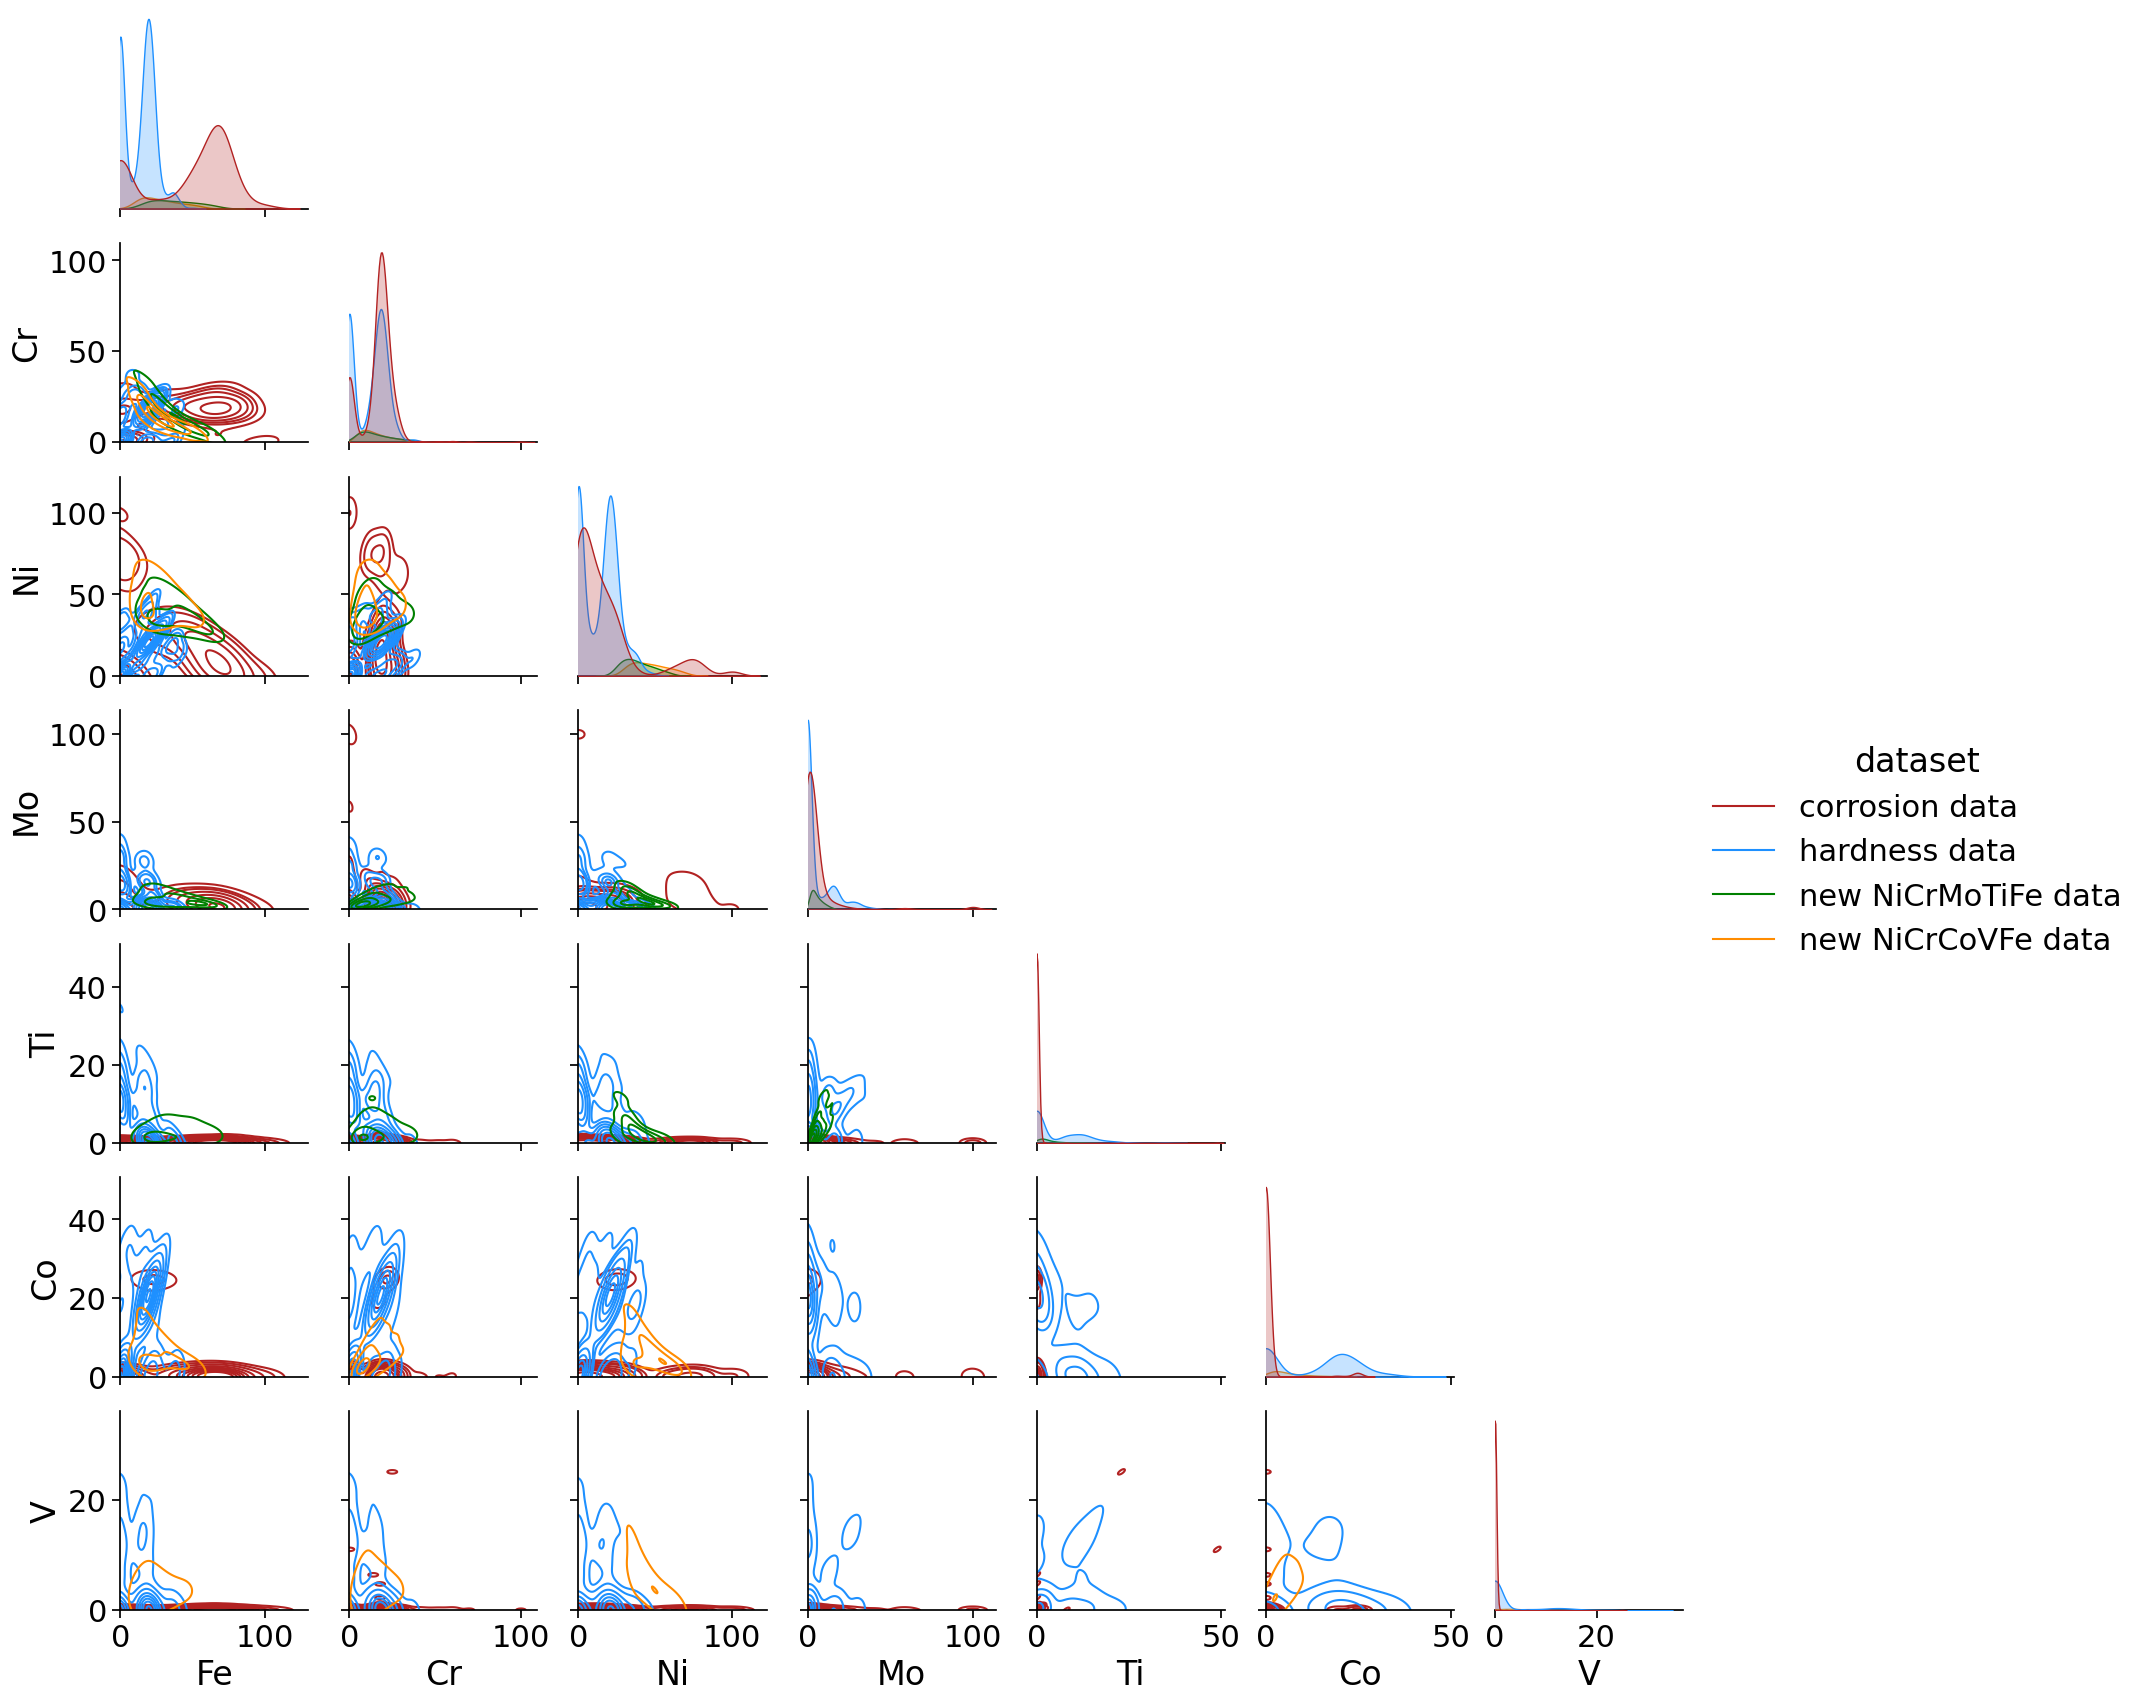

In [26]:
sns.set_context("notebook", font_scale=2)

# Define color palette for the pairplot
palette = ["firebrick", "dodgerblue", "green", "darkorange"]

# Create pairplot with KDE for all data
grid_kde = sns.pairplot(df_compo_conc_new, vars=['Fe', 'Cr', 'Ni', 'Mo', 'Ti', 'Co', 'V'], 
                        hue="dataset", kind="kde", corner=True, palette=palette)

# Adjust x and y limits using list comprehension
_ = [[ax.set_xlim(left=0), ax.set_ylim(bottom=0)] for ax_row in grid_kde.axes for ax in ax_row if ax is not None]

plt.savefig('pairplot_compo_literature+new.png', bbox_inches='tight')

# Show the plots
plt.show()


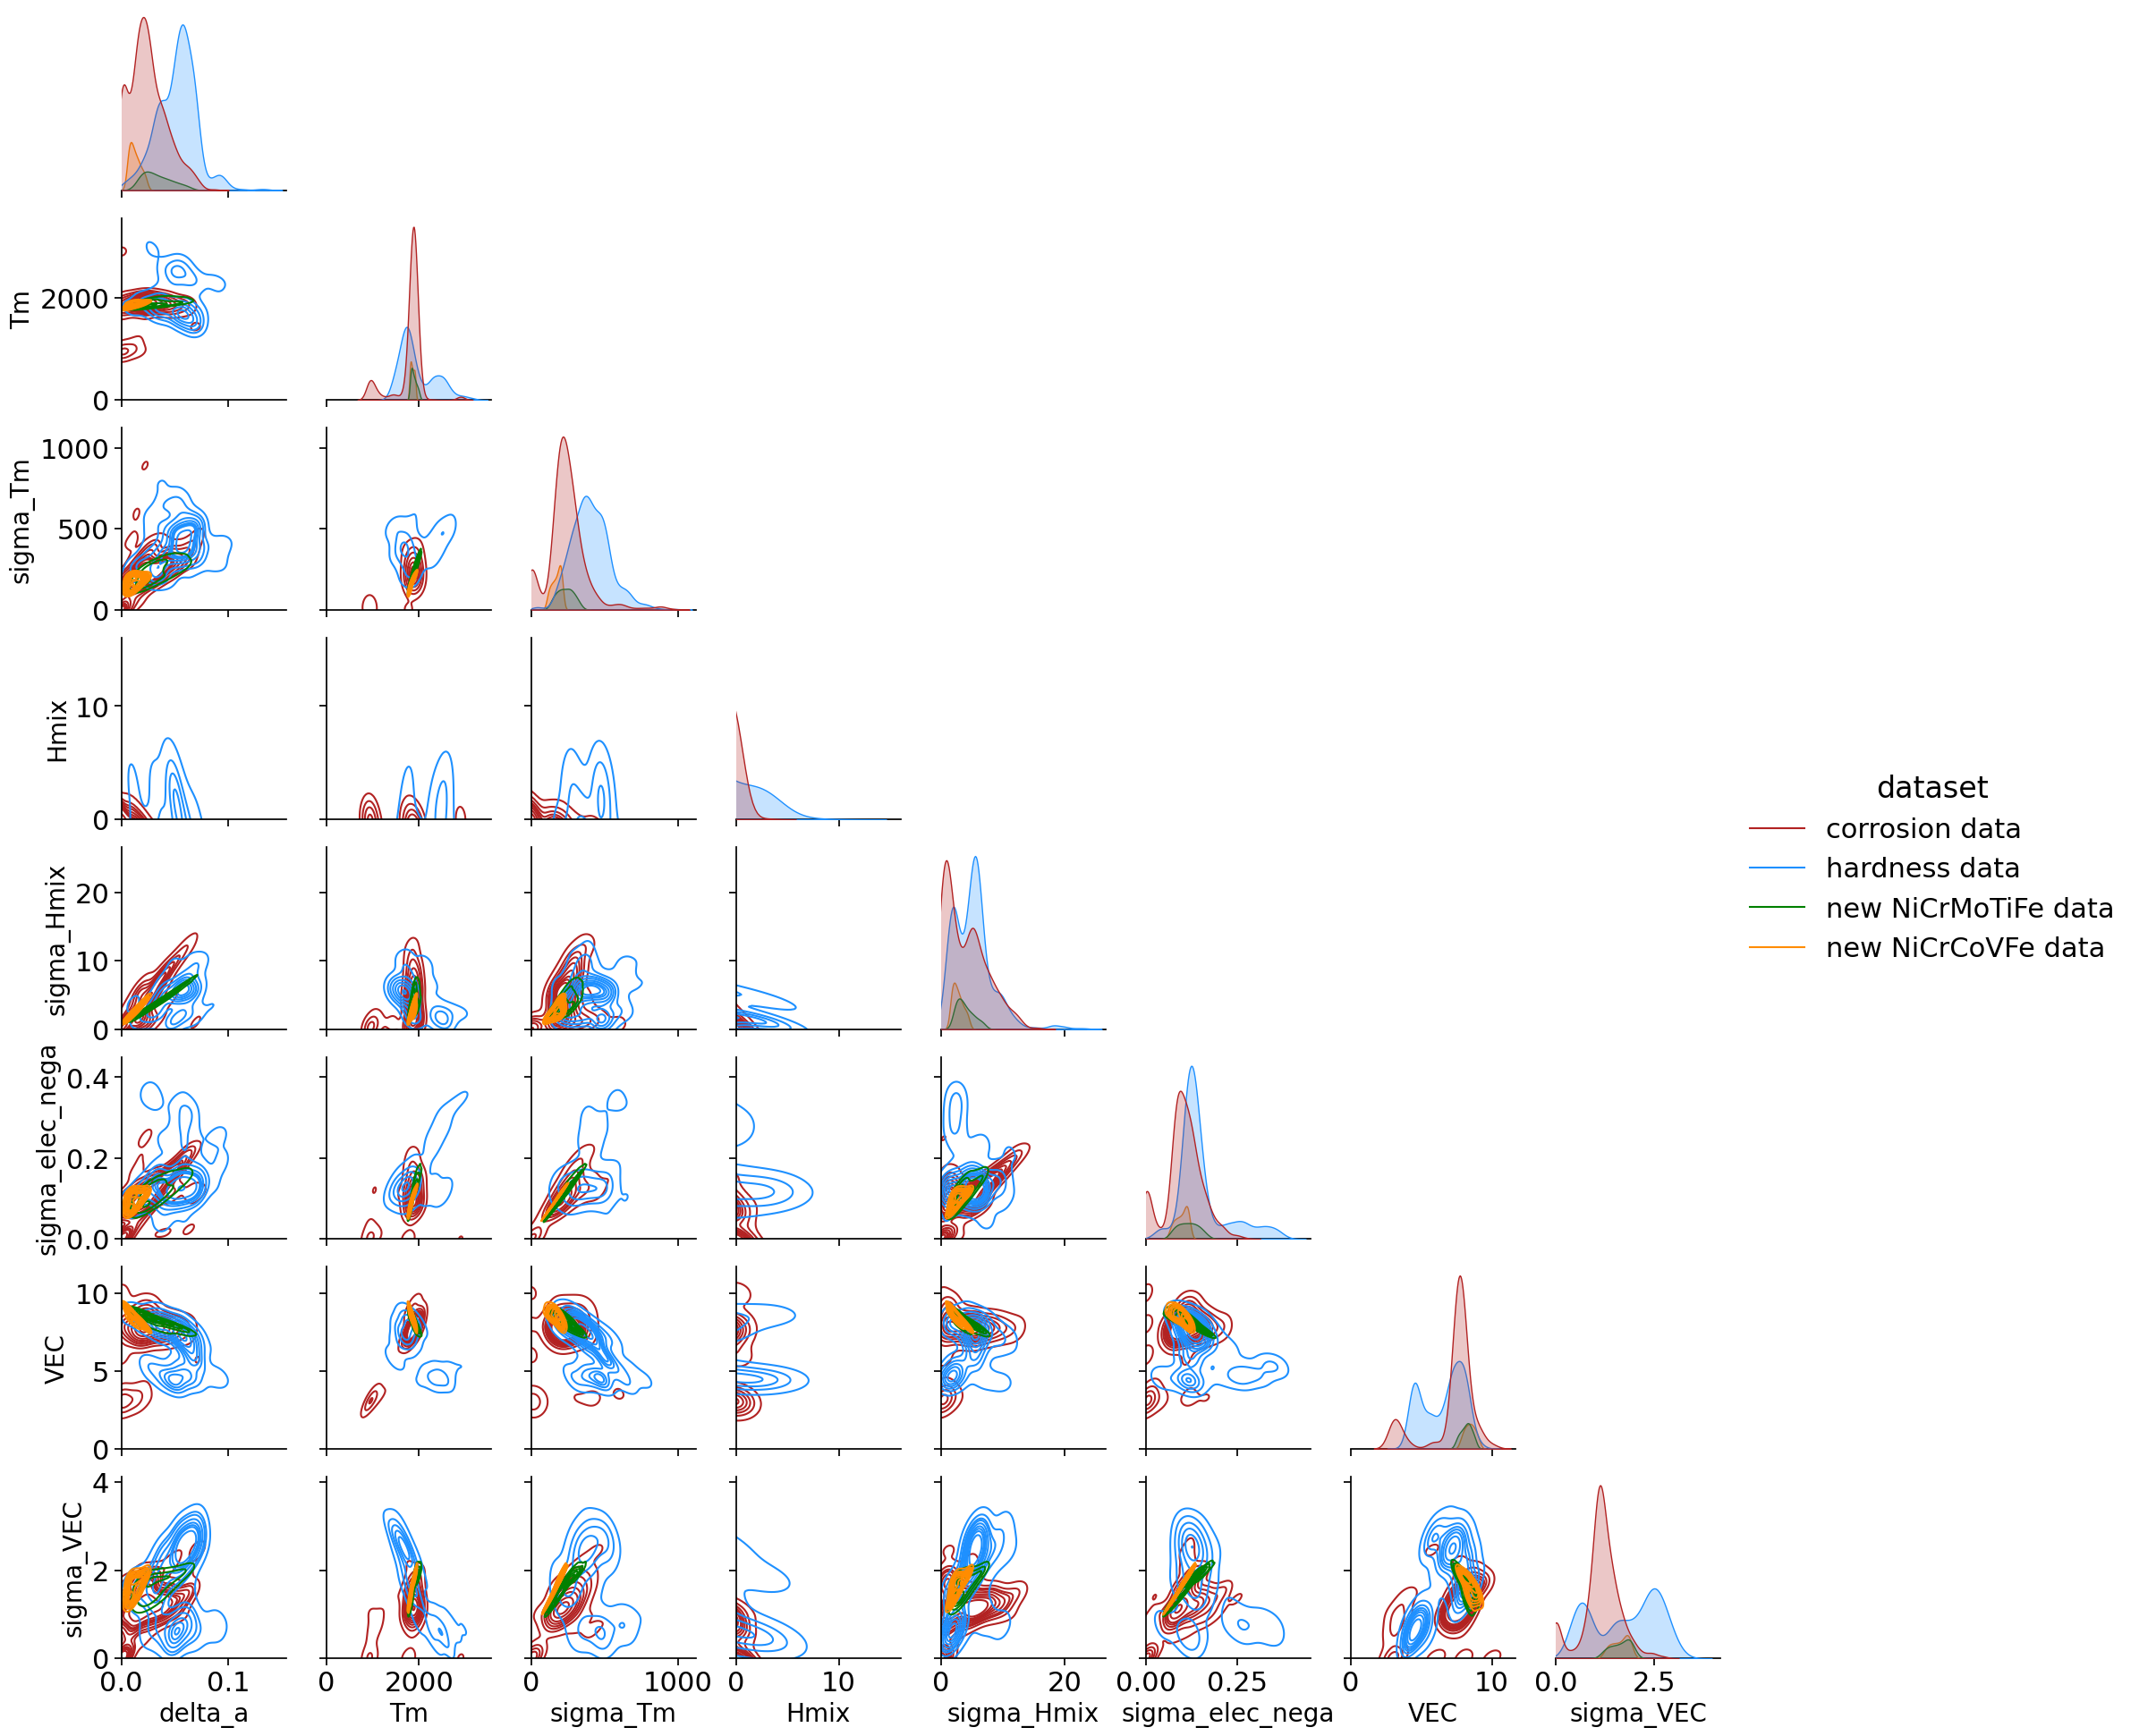

In [28]:
sns.set_context("notebook", font_scale=2)

# Define color palette for the pairplot
palette = ["firebrick", "dodgerblue", "green", "darkorange"]

# Create pairplot with KDE for all data
grid_kde = sns.pairplot(df_compo_specific_features_conc_new, vars=specific_features_sel_column, 
                        hue="dataset", kind="kde", corner=True, palette=palette)

# Adjust x and y limits using list comprehension
_ = [[ax.set_xlim(left=0), 
      ax.set_ylim(bottom=0), 
      ax.xaxis.label.set_size(20), 
      ax.yaxis.label.set_size(20)] for ax_row in grid_kde.axes for ax in ax_row if ax is not None]

plt.savefig('pairplot_compo_literature+new.png', bbox_inches='tight')

# Show the plots
plt.show()

## 1. Let's try PCA (Principal Component Analysis)

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py


In [31]:
display(df_compo_conc_new.head())

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf,dataset
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,corrosion data
1,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,corrosion data
2,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,corrosion data
3,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,corrosion data
4,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,corrosion data


Explained variance ratio (first two components): [2.43393719e-01 1.82871132e-01 1.15271240e-01 9.37253005e-02
 5.25560130e-02 4.97902075e-02 4.83377420e-02 4.64597853e-02
 3.08684212e-02 2.86809425e-02 2.56554372e-02 2.08950011e-02
 1.62171644e-02 1.44652356e-02 1.06770513e-02 8.85869570e-03
 5.41700667e-03 3.85769937e-03 2.00220354e-03 2.02569455e-09]


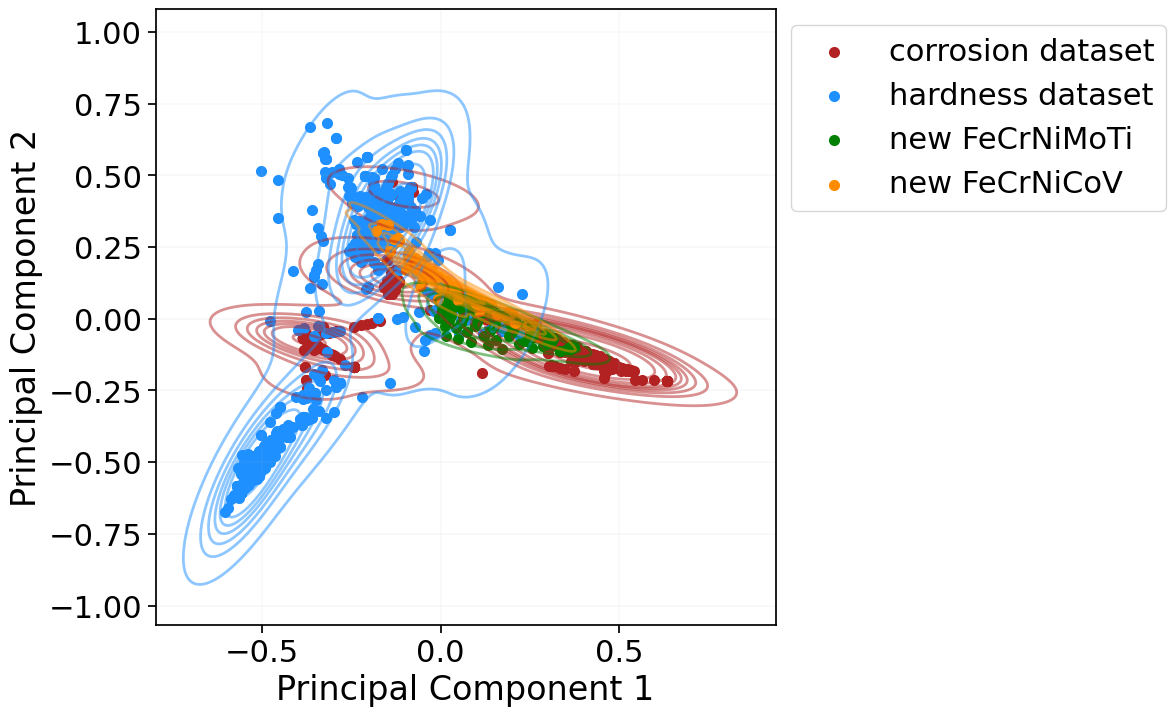

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the dataset for PCA
df_compo_conc_new_pca = df_compo_conc_new.copy()

# Map the "dataset" column to numerical values
dataset_mapping = {"corrosion data": 0, "hardness data": 1, "new NiCrMoTiFe data": 2, "new NiCrCoVFe data": 3}
df_compo_conc_new_pca["dataset"] = df_compo_conc_new_pca["dataset"].map(dataset_mapping)

# MinMax scale the feature set
X_conc = df_compo_conc_new_pca.drop(columns='dataset').values  
X_conc = MinMaxScaler().fit_transform(X_conc)  

y_conc = df_compo_conc_new_pca['dataset'].values  # Target array

# Perform PCA
pca = PCA()
X_conc_r = pca.fit_transform(X_conc)

# Keep first two principal components for visualization
X_conc_r = X_conc_r[:,:2]

# Update the dataframe with PCA1 and PCA2
df_compo_conc_new_pca['PCA1'] = X_conc_r[:, 0]
df_compo_conc_new_pca['PCA2'] = X_conc_r[:, 1]

# Print explained variance ratio
print(f"Explained variance ratio (first two components): {pca.explained_variance_ratio_}")

# plot the projection of PCA analysis
plt.figure(figsize=(8, 8))
colors = ["firebrick", "dodgerblue", "green", "darkorange"]
dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
    plt.scatter(X_conc_r[y_conc == i, 0], X_conc_r[y_conc == i, 1], color=color, alpha=1, lw=2, label=dataset_name)

sns.kdeplot(data=df_compo_conc_new_pca, x="PCA1", y="PCA2", hue='dataset', 
            palette=colors, levels=10, linewidths=2, alpha=0.5, thresh=0.02)

plt.grid(linewidth=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)

plt.savefig('PCA 2D_literature+new.png', bbox_inches='tight')
plt.show()


Explained variance ratio (first two components): [2.34600854e-01 1.94827519e-01 1.33735591e-01 8.74438280e-02
 5.27048916e-02 4.48488992e-02 3.72956460e-02 3.44578423e-02
 3.02714629e-02 2.43134250e-02 2.16965950e-02 1.83765245e-02
 1.59455816e-02 1.45961161e-02 1.21491729e-02 9.64315151e-03
 8.06805342e-03 5.80602258e-03 4.91636861e-03 3.72018940e-03
 2.99950851e-03 2.73711280e-03 2.11344034e-03 1.30119016e-03
 1.06435265e-03 2.77686910e-04 8.89725136e-05 1.30876362e-09]


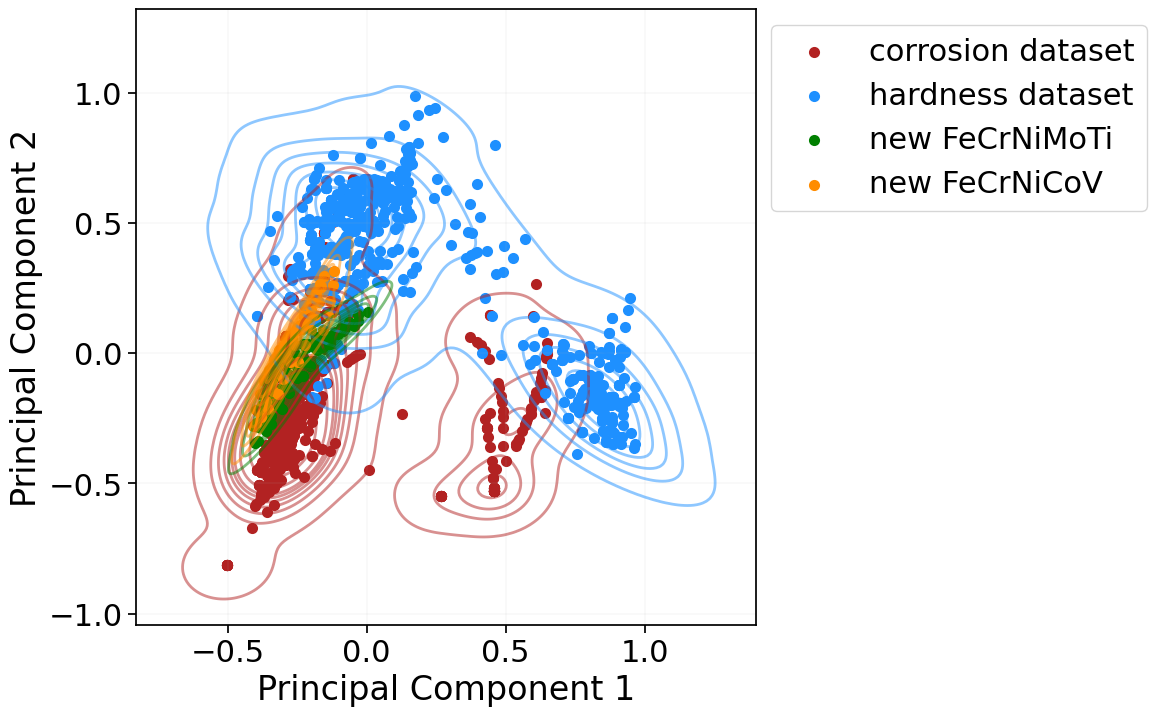

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the dataset for PCA
df_compo_specific_features_conc_new_pca = df_compo_specific_features_conc_new.copy()

# Map the "dataset" column to numerical values
dataset_mapping = {"corrosion data": 0, "hardness data": 1, "new NiCrMoTiFe data": 2, "new NiCrCoVFe data": 3}
df_compo_specific_features_conc_new_pca["dataset"] = df_compo_specific_features_conc_new_pca["dataset"].map(dataset_mapping)

# MinMax scale the feature set
X_conc = df_compo_specific_features_conc_new_pca.drop(columns='dataset').values  
X_conc = MinMaxScaler().fit_transform(X_conc)  

y_conc = df_compo_specific_features_conc_new_pca['dataset'].values  # Target array

# Perform PCA
pca = PCA()
X_conc_r = pca.fit_transform(X_conc)

# Keep first two principal components for visualization
X_conc_r = X_conc_r[:,:2]

# Update the dataframe with PCA1 and PCA2
df_compo_specific_features_conc_new_pca['PCA1'] = X_conc_r[:, 0]
df_compo_specific_features_conc_new_pca['PCA2'] = X_conc_r[:, 1]

# Print explained variance ratio
print(f"Explained variance ratio (first two components): {pca.explained_variance_ratio_}")

# plot the projection of PCA analysis
plt.figure(figsize=(8, 8))
colors = ["firebrick", "dodgerblue", "green", "darkorange"]
dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
    plt.scatter(X_conc_r[y_conc == i, 0], X_conc_r[y_conc == i, 1], color=color, alpha=1, lw=2, label=dataset_name)

sns.kdeplot(data=df_compo_specific_features_conc_new_pca, x="PCA1", y="PCA2", hue='dataset', 
            palette=colors, levels=10, linewidths=2, alpha=0.5, thresh=0.02)

plt.grid(linewidth=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)

plt.savefig('PCA 2D_literature+new.png', bbox_inches='tight')
plt.show()


In [45]:
df_compo_conc_new.shape

(1530, 21)

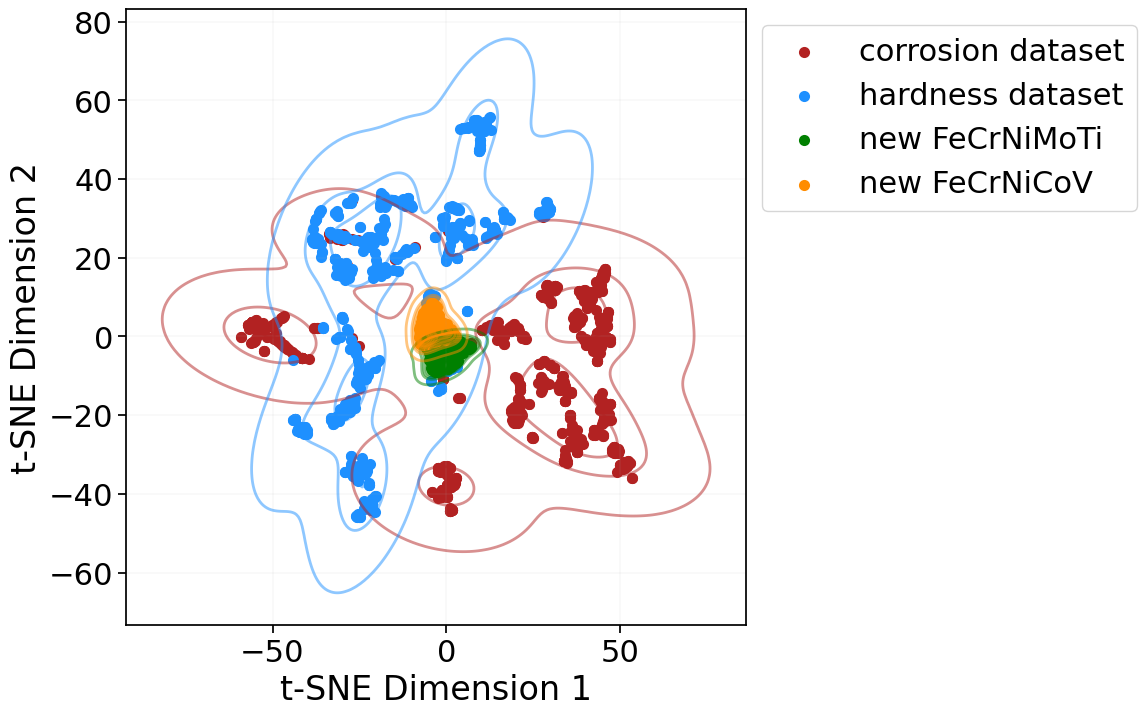

In [58]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the dataset for t-SNE
df_compo_conc_new_tsne = df_compo_conc_new.copy()

# Map the "dataset" column to numerical values
dataset_mapping = {"corrosion data": 0, "hardness data": 1, "new NiCrMoTiFe data": 2, "new NiCrCoVFe data": 3}
df_compo_conc_new_tsne["dataset"] = df_compo_conc_new_tsne["dataset"].map(dataset_mapping)

# MinMax scale the feature set
X_conc = df_compo_conc_new_tsne.drop(columns='dataset').values  
X_conc = MinMaxScaler().fit_transform(X_conc)  

y_conc = df_compo_conc_new_tsne['dataset'].values  # Target array

# Perform t-SNE
tsne = TSNE()
X_conc_r = tsne.fit_transform(X_conc)

# Update the dataframe with t-SNE1 and t-SNE2
df_compo_conc_new_tsne['TSNE1'] = X_conc_r[:, 0]
df_compo_conc_new_tsne['TSNE2'] = X_conc_r[:, 1]

# plot the projection of t-SNE analysis
plt.figure(figsize=(8, 8))
colors = ["firebrick", "dodgerblue", "green", "darkorange"]
dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
    plt.scatter(X_conc_r[y_conc == i, 0], X_conc_r[y_conc == i, 1], color=color, alpha=1, lw=2, label=dataset_name)

sns.kdeplot(data=df_compo_conc_new_tsne, x="TSNE1", y="TSNE2", hue='dataset', 
            palette=colors, levels=10, linewidths=2, alpha=0.5, thresh=0.002)

plt.grid(linewidth=0.1)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)

plt.savefig('tSNE_2D_literature+new.png', bbox_inches='tight')
plt.show()


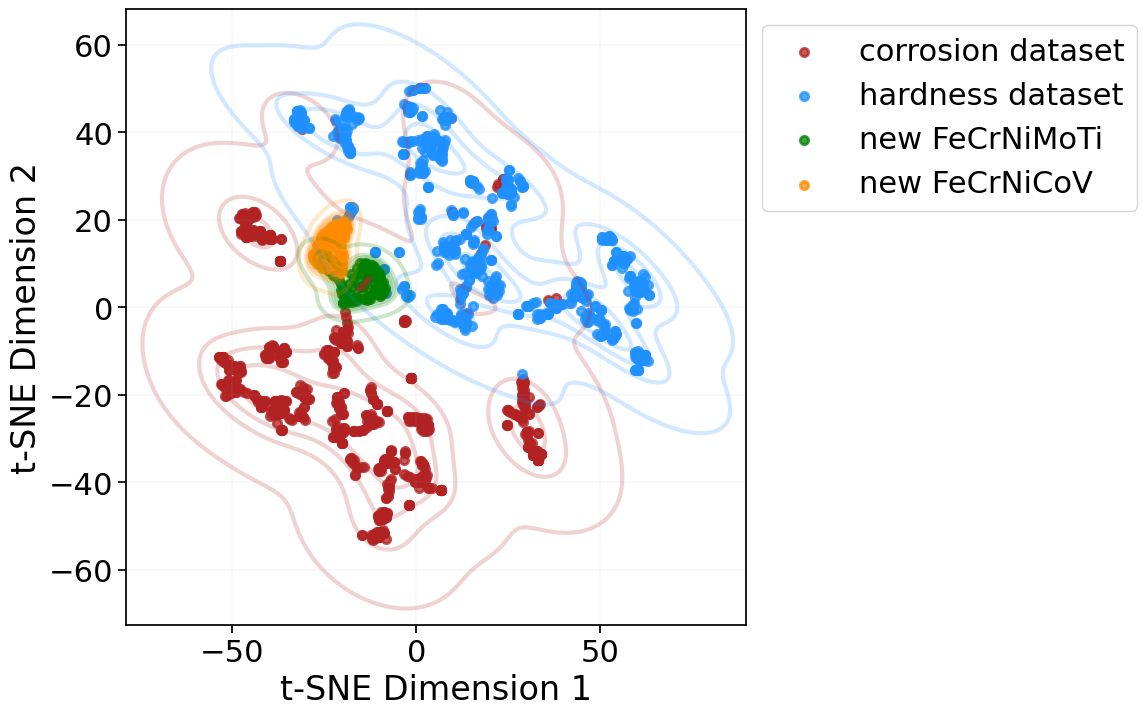

In [63]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the dataset for t-SNE
df_compo_specific_features_conc_new_tsne = df_compo_specific_features_conc_new.copy()

# Map the "dataset" column to numerical values
dataset_mapping = {"corrosion data": 0, "hardness data": 1, "new NiCrMoTiFe data": 2, "new NiCrCoVFe data": 3}
df_compo_specific_features_conc_new_tsne["dataset"] = df_compo_specific_features_conc_new_tsne["dataset"].map(dataset_mapping)

# MinMax scale the feature set
X_conc = df_compo_specific_features_conc_new_tsne.drop(columns='dataset').values  
X_conc = MinMaxScaler().fit_transform(X_conc)  

y_conc = df_compo_specific_features_conc_new_tsne['dataset'].values  # Target array

# Perform t-SNE
tsne = TSNE()
X_conc_r = tsne.fit_transform(X_conc)

# Update the dataframe with t-SNE1 and t-SNE2
df_compo_specific_features_conc_new_tsne['TSNE1'] = X_conc_r[:, 0]
df_compo_specific_features_conc_new_tsne['TSNE2'] = X_conc_r[:, 1]

# plot the projection of t-SNE analysis
plt.figure(figsize=(8, 8))
colors = ["firebrick", "dodgerblue", "green", "darkorange"]
dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
    plt.scatter(X_conc_r[y_conc == i, 0], X_conc_r[y_conc == i, 1], color=color, alpha=0.75, lw=2, label=dataset_name)

sns.kdeplot(data=df_compo_specific_features_conc_new_tsne, x="TSNE1", y="TSNE2", hue='dataset', 
            palette=colors, levels=10, linewidths=3, alpha=0.2, thresh=0.002)

plt.grid(linewidth=0.1)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)

plt.savefig('tSNE_2D_literature+new.png', bbox_inches='tight')
plt.show()


In [44]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Prepare the datasets for PCA
# df1 = df_compo_conc_new.copy()
# df2 = df_compo_specific_features_conc_new.copy()

# # Map the "dataset" column to numerical values
# dataset_mapping = {"corrosion data": 0, "hardness data": 1, "new NiCrMoTiFe data": 2, "new NiCrCoVFe data": 3}
# df1["dataset"] = df1["dataset"].map(dataset_mapping)
# df2["dataset"] = df2["dataset"].map(dataset_mapping)

# # MinMax scale the feature set
# scaler = MinMaxScaler()

# X1 = scaler.fit_transform(df1.drop(columns='dataset').values)
# X2 = scaler.transform(df2.drop(columns='dataset').values)

# y1 = df1['dataset'].values  # Target array
# y2 = df2['dataset'].values

# # Perform PCA
# pca = PCA()
# X1_r = pca.fit_transform(X1)
# X2_r = pca.transform(X2)

# # Keep first two principal components for visualization
# X1_r = X1_r[:,:2]
# X2_r = X2_r[:,:2]

# # Update the dataframe with PCA1 and PCA2
# df1['PCA1'] = X1_r[:, 0]
# df1['PCA2'] = X1_r[:, 1]
# df2['PCA1'] = X2_r[:, 0]
# df2['PCA2'] = X2_r[:, 1]

# # Print explained variance ratio
# print(f"Explained variance ratio (first two components) for dataset 1: {pca.explained_variance_ratio_}")

# # plot the projection of PCA analysis
# fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# colors = ["firebrick", "dodgerblue", "green", "darkorange"]
# dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

# for ax, X_r, y, df, title in zip(axs, [X1_r, X2_r], [y1, y2], [df1, df2], ["Dataset 1", "Dataset 2"]):
#     for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
#         ax.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=1, lw=2, label=dataset_name)

#     sns.kdeplot(data=df, x="PCA1", y="PCA2", hue='dataset', 
#                 palette=colors, levels=10, linewidths=2, alpha=0.5, thresh=0.02, ax=ax)

#     ax.grid(linewidth=0.1)
#     ax.set_xlabel('Principal Component 1')
#     ax.set_ylabel('Principal Component 2')
#     ax.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)
#     ax.set_title(title)

# plt.savefig('PCA 2D_literature+new.png', bbox_inches='tight')
# plt.show()


ValueError: X has 28 features, but MinMaxScaler is expecting 20 features as input.

## 2. Let's try to use the concept of outlier/novelty detection - using Mahalanobis distance

### Approach Multivariate Outliers and Mahalanobis Distance (simple approach)

https://www.geeksforgeeks.org/how-to-calculate-mahalanobis-distance-in-python/
https://www.machinelearningplus.com/statistics/mahalanobis-distance/
https://scikit-learn.org/stable/modules/outlier_detection.html


In [8]:
import scipy.stats as stats
from scipy.stats import chi2
import numpy as np

In [9]:
df_C_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 0]
df_H_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 1]
df_new_FeCrNiMoTi_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 2]
df_new_FeCrNiCoV_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 3]


# prepare the df for calculating Mahalanobis distance (cannot have string in df)
display(df_C_pca.iloc[[0, -1]], df_C_pca.shape, 
        df_H_pca.iloc[[0, -1]], df_H_pca.shape, 
        df_new_FeCrNiMoTi_pca.iloc[[0, -1]], df_new_FeCrNiMoTi_pca.shape,
        df_new_FeCrNiCoV_pca.iloc[[0, -1]], df_new_FeCrNiCoV_pca.shape)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
0,69.77,18.00,10.0,0.0,0.0,0.0,0.0,0.03,1.00,1.00,...,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,40.544503,-9.952558
711,0.16,0.23,0.0,0.0,0.0,0.0,0.0,0.00,0.08,0.02,...,0.0,0.0,0.0,2.43,0.0,0,0.0,0.0,-58.871892,-61.840695


(712, 23)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
712,19.92,18.54,20.93,0.00,0.0,0.0,0.0,0.0,0.0,19.59,...,0.0,0.0,21.02,0.0,0.0,1,0.0,0.0,-5.402516,12.239616
1391,20.17,0.00,42.40,6.93,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,21.29,0.0,0.0,1,0.0,0.0,-9.865660,26.057831


(680, 23)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
1392,14.316994,35.210247,45.453038,4.138939,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.880782,0.0,0.0,0.0,2,0.0,0.0,-8.226433,31.248550
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.078709,0.0,0.0,0.0,2,0.0,0.0,31.837815,0.103357


(69, 23)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
1461,10.271486,31.290494,51.985556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.851446,0.0,0.0,3,0.0,0.0,-12.580944,37.136561
1529,51.347188,5.827793,31.584854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.097870,0.0,0.0,3,0.0,0.0,21.118125,9.488586


(69, 23)

### preparing the existing datasets (literature+new)


In [10]:
# Merge existing and new datasets, replacing missing values with 0
df_C_new_FeCrNiMoTi = pd.concat([df_C_pca, df_new_FeCrNiMoTi_pca], ignore_index=True).fillna(0)
df_C_new_FeCrNiCoV = pd.concat([df_C_pca, df_new_FeCrNiCoV_pca], ignore_index=True).fillna(0)
df_H_new_FeCrNiMoTi = pd.concat([df_H_pca, df_new_FeCrNiMoTi_pca], ignore_index=True).fillna(0)
df_H_new_FeCrNiCoV = pd.concat([df_H_pca, df_new_FeCrNiCoV_pca], ignore_index=True).fillna(0)

def process_df_Mahal(df): 
    df_num = df.loc[:, ~df.columns.isin(['dataset', 'PCA1', 'PCA2'])]
    df_label = df[['dataset', 'PCA1', 'PCA2']]

    # Detect zero columns using 'all' method after comparing with 0
    zero_columns = (df_num == 0).all()

    # Print the names of the columns containing only zeros with context
    print("Columns only containing zeros:", zero_columns[zero_columns].index.tolist())

    # Drop the zero columns using boolean indexing 
    df_num = df_num.loc[:, ~zero_columns]

    return df_num, df_label

# Process each dataframe and separate numerical and label data
df_C_new_FeCrNiMoTi_num, df_C_new_FeCrNiMoTi_label = process_df_Mahal(df_C_new_FeCrNiMoTi)
df_C_new_FeCrNiCoV_num, df_C_new_FeCrNiCoV_label = process_df_Mahal(df_C_new_FeCrNiCoV)
df_H_new_FeCrNiMoTi_num, df_H_new_FeCrNiMoTi_label = process_df_Mahal(df_H_new_FeCrNiMoTi)
df_H_new_FeCrNiCoV_num, df_H_new_FeCrNiCoV_label = process_df_Mahal(df_H_new_FeCrNiCoV)
  
display(df_C_new_FeCrNiMoTi_num.iloc[[0,-1]], df_C_new_FeCrNiMoTi_label.iloc[[0,-1]])
 

Columns only containing zeros: ['Zr', 'Hf']
Columns only containing zeros: ['Zr', 'Hf']
Columns only containing zeros: ['N', 'Mg']
Columns only containing zeros: ['N', 'Mg']


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
780,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.078709,0.0,0.0,0.0


,dataset,PCA1,PCA2
0,0,40.544503,-9.952558
780,2,31.837815,0.103357


### calculate the Mahalanobis distance


In [11]:
df_C_new_FeCrNiMoTi_Mahl = df_C_new_FeCrNiMoTi_num.copy()
df_C_new_FeCrNiCoV_Mahl = df_C_new_FeCrNiCoV_num.copy()
df_H_new_FeCrNiMoTi_Mahl = df_H_new_FeCrNiMoTi_num.copy()
df_H_new_FeCrNiCoV_Mahl = df_H_new_FeCrNiCoV_num.copy()

# Function to calculate the Mahalanobis distance of each point to the "center" of the dataset 
def calculateMahalanobis(y=None, data=None, cov=None):
    # Compute the Mahalanobis Distance between each row of y and the data  
    # y    : matrix of data with, say, p columns (new observation).
    # data : ndarray of the distribution (existing data), from which Mahalanobis distance of each observation of y is to be computed.
    # cov  : covariance matrix (p x p) of the distribution(existing data). If None, will be computed from data.
   
    y_mu = y - np.mean(data, axis=0)
    if cov is None:
        cov = np.cov(data.values.T)
        cov += np.eye(cov.shape[0]) * 1e-6
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)

    # print(y_mu.isna().sum().sum())  # check if y_mu has any NaN
    # print(inv_covmat)  # see the inverse covariance matrix
    return mahal.diagonal()

# y: new observation, data: existing data from which Mahalanobis distance is to be computed.
df_C_new_FeCrNiMoTi_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_C_new_FeCrNiMoTi_Mahl, data= df_C_new_FeCrNiMoTi_num)
df_C_new_FeCrNiCoV_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_C_new_FeCrNiCoV_Mahl, data= df_C_new_FeCrNiCoV_num)
df_H_new_FeCrNiMoTi_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_H_new_FeCrNiMoTi_Mahl, data= df_H_new_FeCrNiMoTi_num)
df_H_new_FeCrNiCoV_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_H_new_FeCrNiCoV_Mahl, data= df_H_new_FeCrNiCoV_num)

display(df_C_new_FeCrNiMoTi_Mahl.head(1))
display(df_C_new_FeCrNiCoV_Mahl.head(1))
display(df_H_new_FeCrNiMoTi_Mahl.head(1))
display(df_H_new_FeCrNiCoV_Mahl.head(1))


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Mahalanobis
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.565848


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Mahalanobis
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.400106


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Y,Zr,Hf,Mahalanobis
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0.0,0.0,0.0,7.810072


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Y,Zr,Hf,Mahalanobis
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0.0,0.0,0.0,7.933566


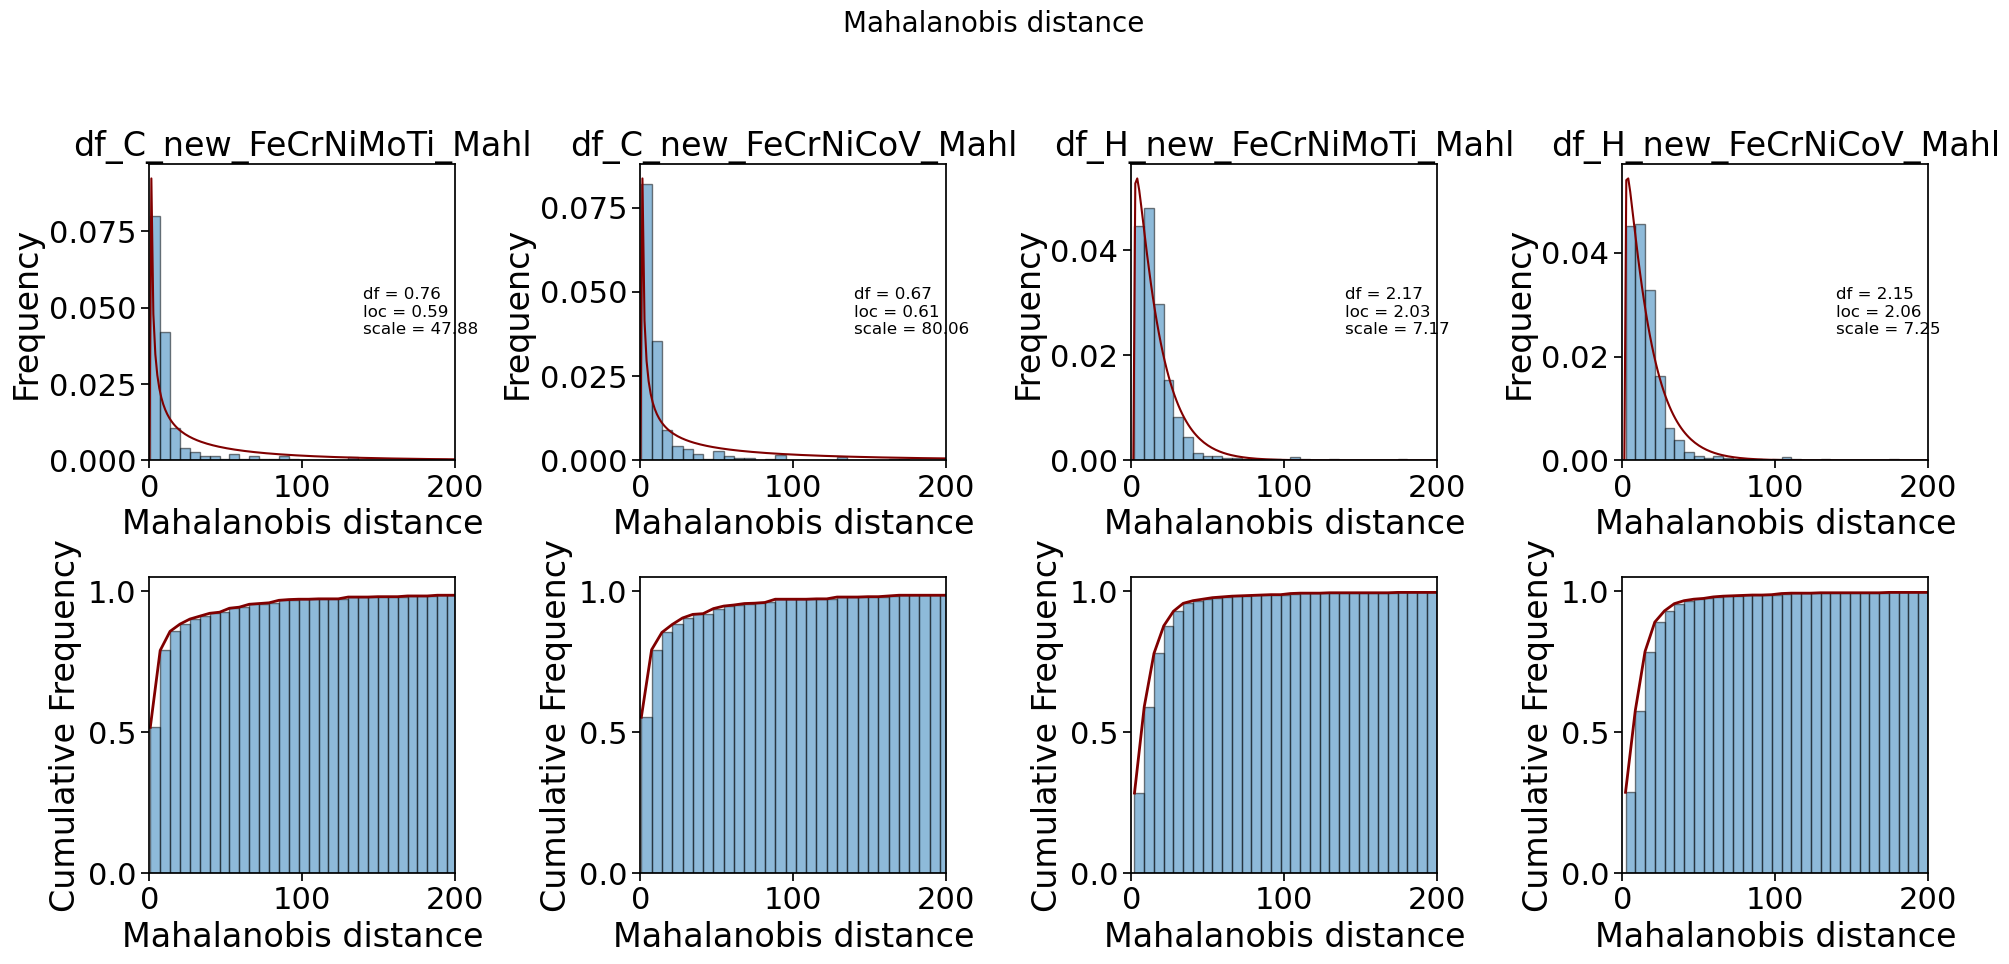

In [12]:
# Define dataframes in a list
dfs = [df_C_new_FeCrNiMoTi_Mahl, df_C_new_FeCrNiCoV_Mahl, df_H_new_FeCrNiMoTi_Mahl, df_H_new_FeCrNiCoV_Mahl]
titles = ['df_C_new_FeCrNiMoTi_Mahl', 'df_C_new_FeCrNiCoV_Mahl', 'df_H_new_FeCrNiMoTi_Mahl', 'df_H_new_FeCrNiCoV_Mahl']

# Set up subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Mahalanobis distance', fontsize=20)

# Iterate through dataframes
for i, df in enumerate(dfs):
    # Plot histogram
    axs[0,i].hist(df['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, density=True)
    axs[0,i].set_xlabel('Mahalanobis distance')
    axs[0,i].set_ylabel('Frequency')
    axs[0,i].set_xlim(0, 200)
    axs[0,i].set_title(titles[i])

    # Fit a chi-squared distribution to the data
    df_param, loc, scale = stats.chi2.fit(df['Mahalanobis'])
    # Plot the fitted distribution over the histogram
    x_chi2 = np.linspace(0, np.amax(df['Mahalanobis']), 500)
    pdf_chi2 = stats.chi2.pdf(x_chi2, df=df_param, loc=loc, scale=scale)
    axs[0,i].plot(x_chi2, pdf_chi2, 'maroon')
    # Add the fitted values to the plot
    axs[0,i].text(0.7, 0.5, f"df = {df_param:.2f}\nloc = {loc:.2f}\nscale = {scale:.2f}",
                  transform=axs[0,i].transAxes, ha='left', va='center', fontsize=12)

    # Plot CDF
    counts, bins, patches = axs[1,i].hist(df['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, cumulative=True, density=True)
    axs[1,i].plot(bins[:-1], counts, 'maroon', lw=2)
    axs[1,i].set_xlim(0, 200)
    axs[1,i].set_xlabel('Mahalanobis distance')
    axs[1,i].set_ylabel('Cumulative Frequency')

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent overlapping
plt.show()


### 3. Let's use chi2 statistics to get a more presentable number: p-value based on chi2 distribution with degree of freedom = 2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4381501/


In [13]:
# calculate p-value for each mahalanobis distance using 
df_C_new_FeCrNiMoTi_Mahl['p value'] = 1 - chi2.cdf(df_C_new_FeCrNiMoTi_Mahl['Mahalanobis'], 2)
df_C_new_FeCrNiCoV_Mahl['p value'] = 1 - chi2.cdf(df_C_new_FeCrNiCoV_Mahl['Mahalanobis'], 2)
df_H_new_FeCrNiMoTi_Mahl['p value'] = 1 - chi2.cdf(df_H_new_FeCrNiMoTi_Mahl['Mahalanobis'], 2)
df_H_new_FeCrNiCoV_Mahl['p value'] = 1 - chi2.cdf(df_H_new_FeCrNiCoV_Mahl['Mahalanobis'], 2)

# re-attach the labels
df_C_new_FeCrNiMoTi_Mahl_label = pd.concat([df_C_new_FeCrNiMoTi_Mahl,  df_C_new_FeCrNiMoTi_label], axis=1)
df_C_new_FeCrNiCoV_Mahl_label = pd.concat([df_C_new_FeCrNiCoV_Mahl,  df_C_new_FeCrNiCoV_label], axis=1)
df_H_new_FeCrNiMoTi_Mahl_label = pd.concat([df_H_new_FeCrNiMoTi_Mahl,  df_H_new_FeCrNiMoTi_label], axis=1)
df_H_new_FeCrNiCoV_Mahl_label = pd.concat([df_H_new_FeCrNiCoV_Mahl,  df_H_new_FeCrNiCoV_label], axis=1)

display(df_C_new_FeCrNiMoTi_Mahl_label.iloc[[0,-1]])



,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,Mahalanobis,p value,dataset,PCA1,PCA2
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,2.565848,0.277225,0,40.544503,-9.952558
780,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,4.078709,0.0,0.0,0.0,7.075902,0.029073,2,31.837815,0.103357


In [14]:
# # now re-attach the label
# df_new_Mahal  = pd.concat([df_new_num_Mahal,  df_new_label], axis=1)
# df_conc_Mahal = pd.concat([df_conc_num_Mahal, df_conc_label], axis=1)
# print(df_new_Mahal.tail(3))

# # "df_conc_Mahal" is from method 2 to evalute the Mahalanobis distance when including all data
# # only select the "new" dataset from the overall "training+new"
# df_conc_Mahal_new = df_conc_Mahal[df_conc_Mahal["dataset"]== 1 ]
# print(df_conc_Mahal_new.tail(3))


#### If we believe the p value from chi2 statistics can be a measure of "novelty" (smaller ones are more likely outliers), we plot it back to PCA 2D project and also PVD representation


1. map the chi2 pvalues to the PCA 2D projection: it seems the variation of p value is NOT monotonic on this 2D projection
   I mainly highlighted the "new" dataset (you can still see the translucent "training" data points)


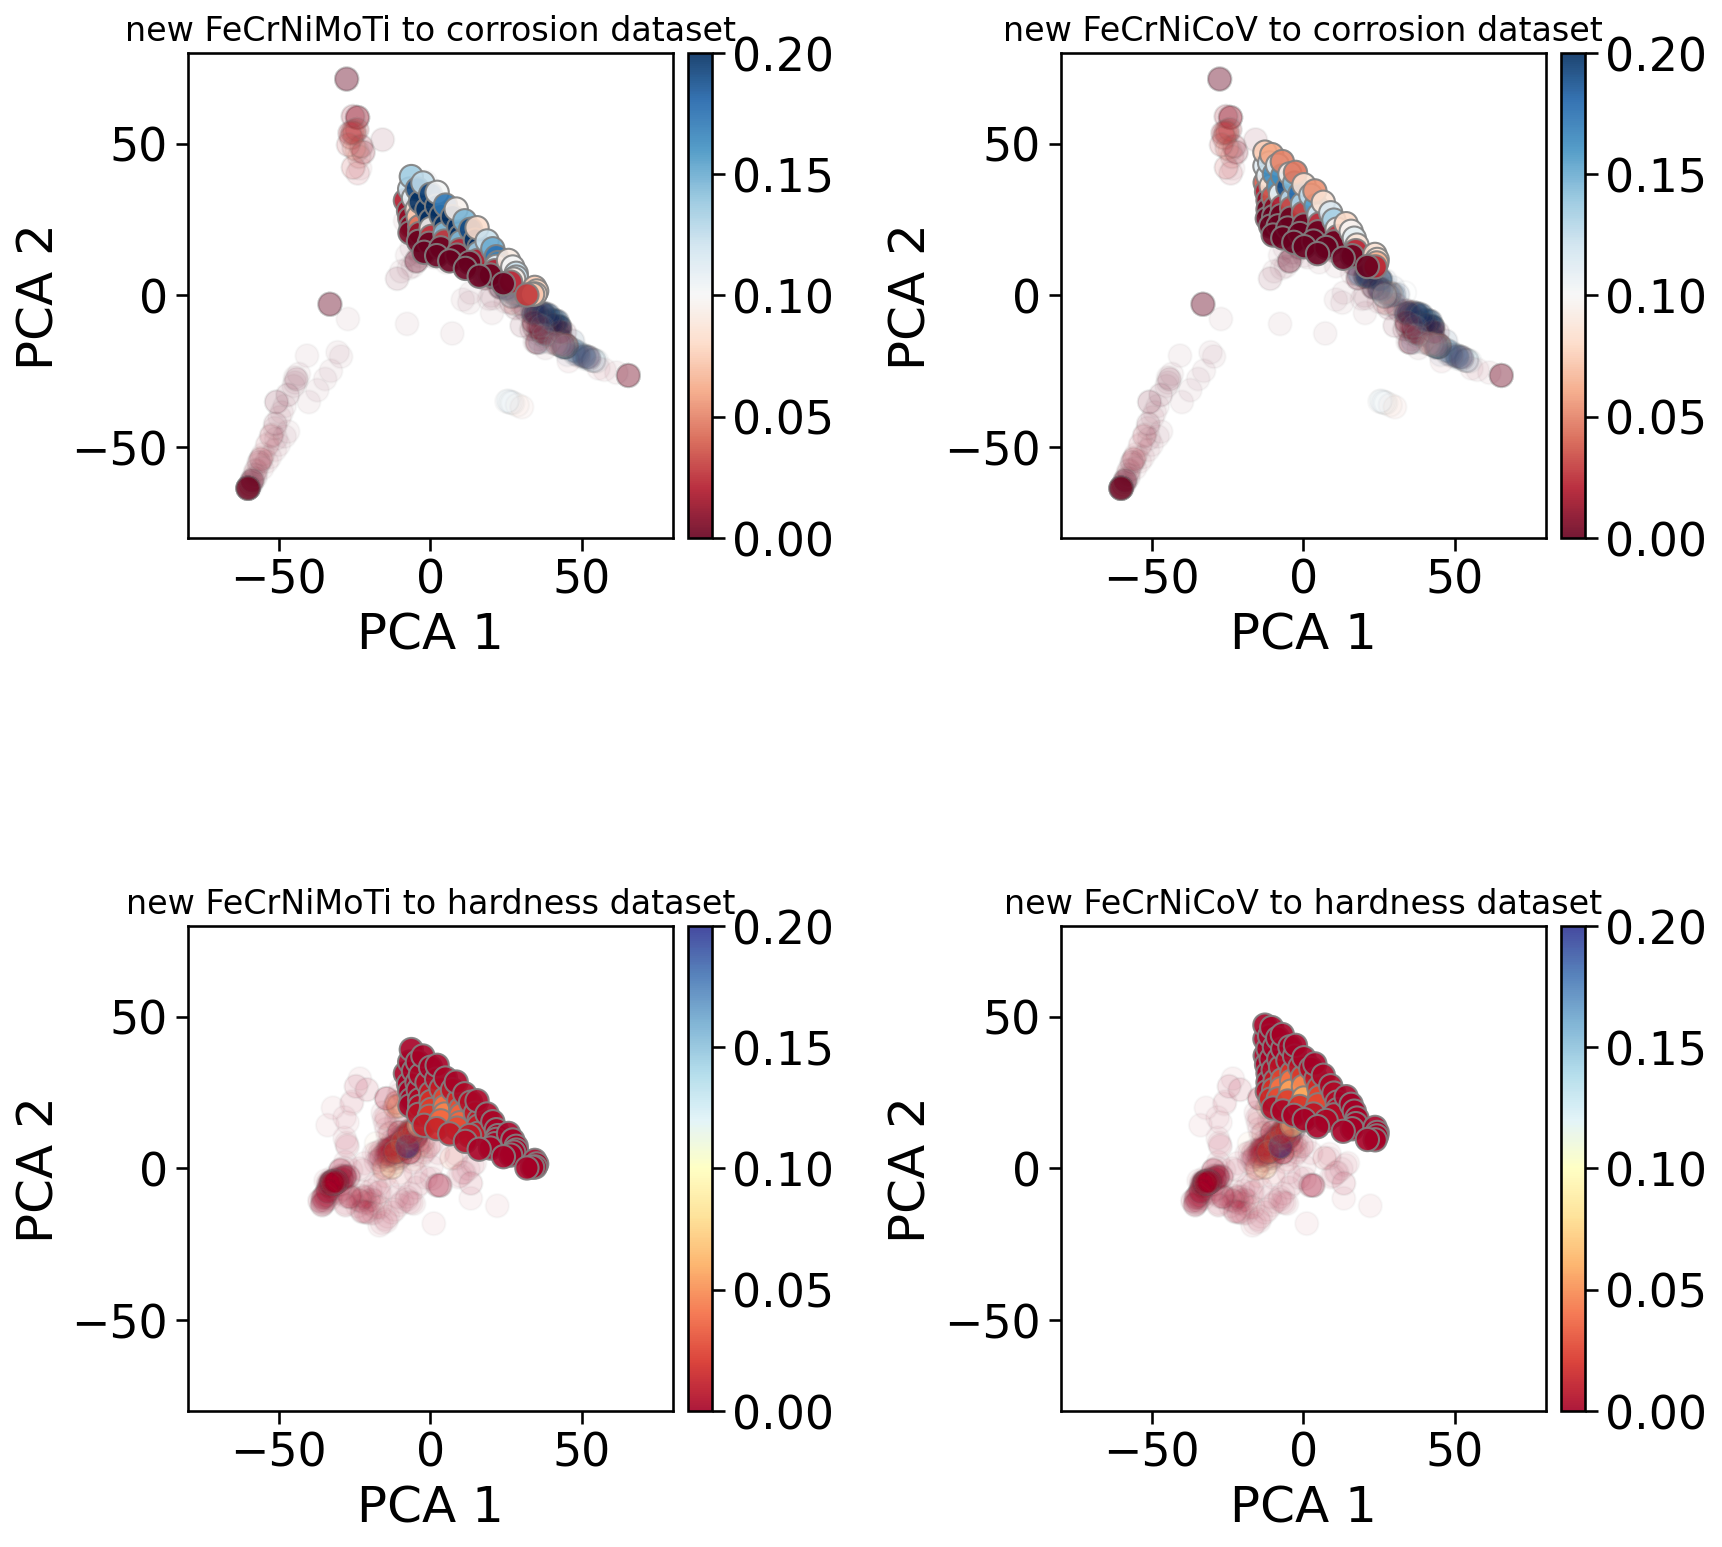

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def create_scatter(df, dataset_values, ax, cmap="RdBu", titlename = "name?"):
    # Create separate dataframes for each dataset
    df_literature = df[df["dataset"] == dataset_values[0]]
    df_new = df[df["dataset"] == dataset_values[1]]

    # Create the scatter plots
    scatters = []
    for df, alpha in zip([df_literature, df_new], [0.05, 0.9]):
        scatter = ax.scatter(df["PCA1"], df["PCA2"], c=df["p value"], cmap=cmap, edgecolor="grey", 
                             s=500, marker='.', alpha=alpha, vmin=0, vmax=0.2)
        scatters.append(scatter)

        ax.set_xlim(-80, 80)
        ax.set_ylim(-80, 80)
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        # set the subplot title to the dataset name
        ax.set_title(titlename, fontsize=16)
        # make equal aspect ratio
        ax.set_aspect('equal', 'box')

    return scatters

# create the subplots of 2x2
fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=150)

datasets = [(df_C_new_FeCrNiMoTi_Mahl_label, [0, 2], "RdBu", "new FeCrNiMoTi to corrosion dataset"),
            (df_C_new_FeCrNiCoV_Mahl_label, [0, 3], "RdBu", "new FeCrNiCoV to corrosion dataset"),
            (df_H_new_FeCrNiMoTi_Mahl_label, [1, 2], "RdYlBu", "new FeCrNiMoTi to hardness dataset"),
            (df_H_new_FeCrNiCoV_Mahl_label, [1, 3], "RdYlBu", "new FeCrNiCoV to hardness dataset")]

for i, (df, dataset_values, cmap, title) in enumerate(datasets):
    axi = ax[i//2, i%2]  # Get the current axis
    scatters = create_scatter(df, dataset_values, axi, cmap=cmap, titlename=title)

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(axi)
    # Append axes for colorbar to the right of axi, with 5% width of axi
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(scatters[-1], cax=cax)

plt.tight_layout()
plt.savefig('PCA 2D_Mahalanobis.png')
plt.show()

Now I will plot the p value on the wafer


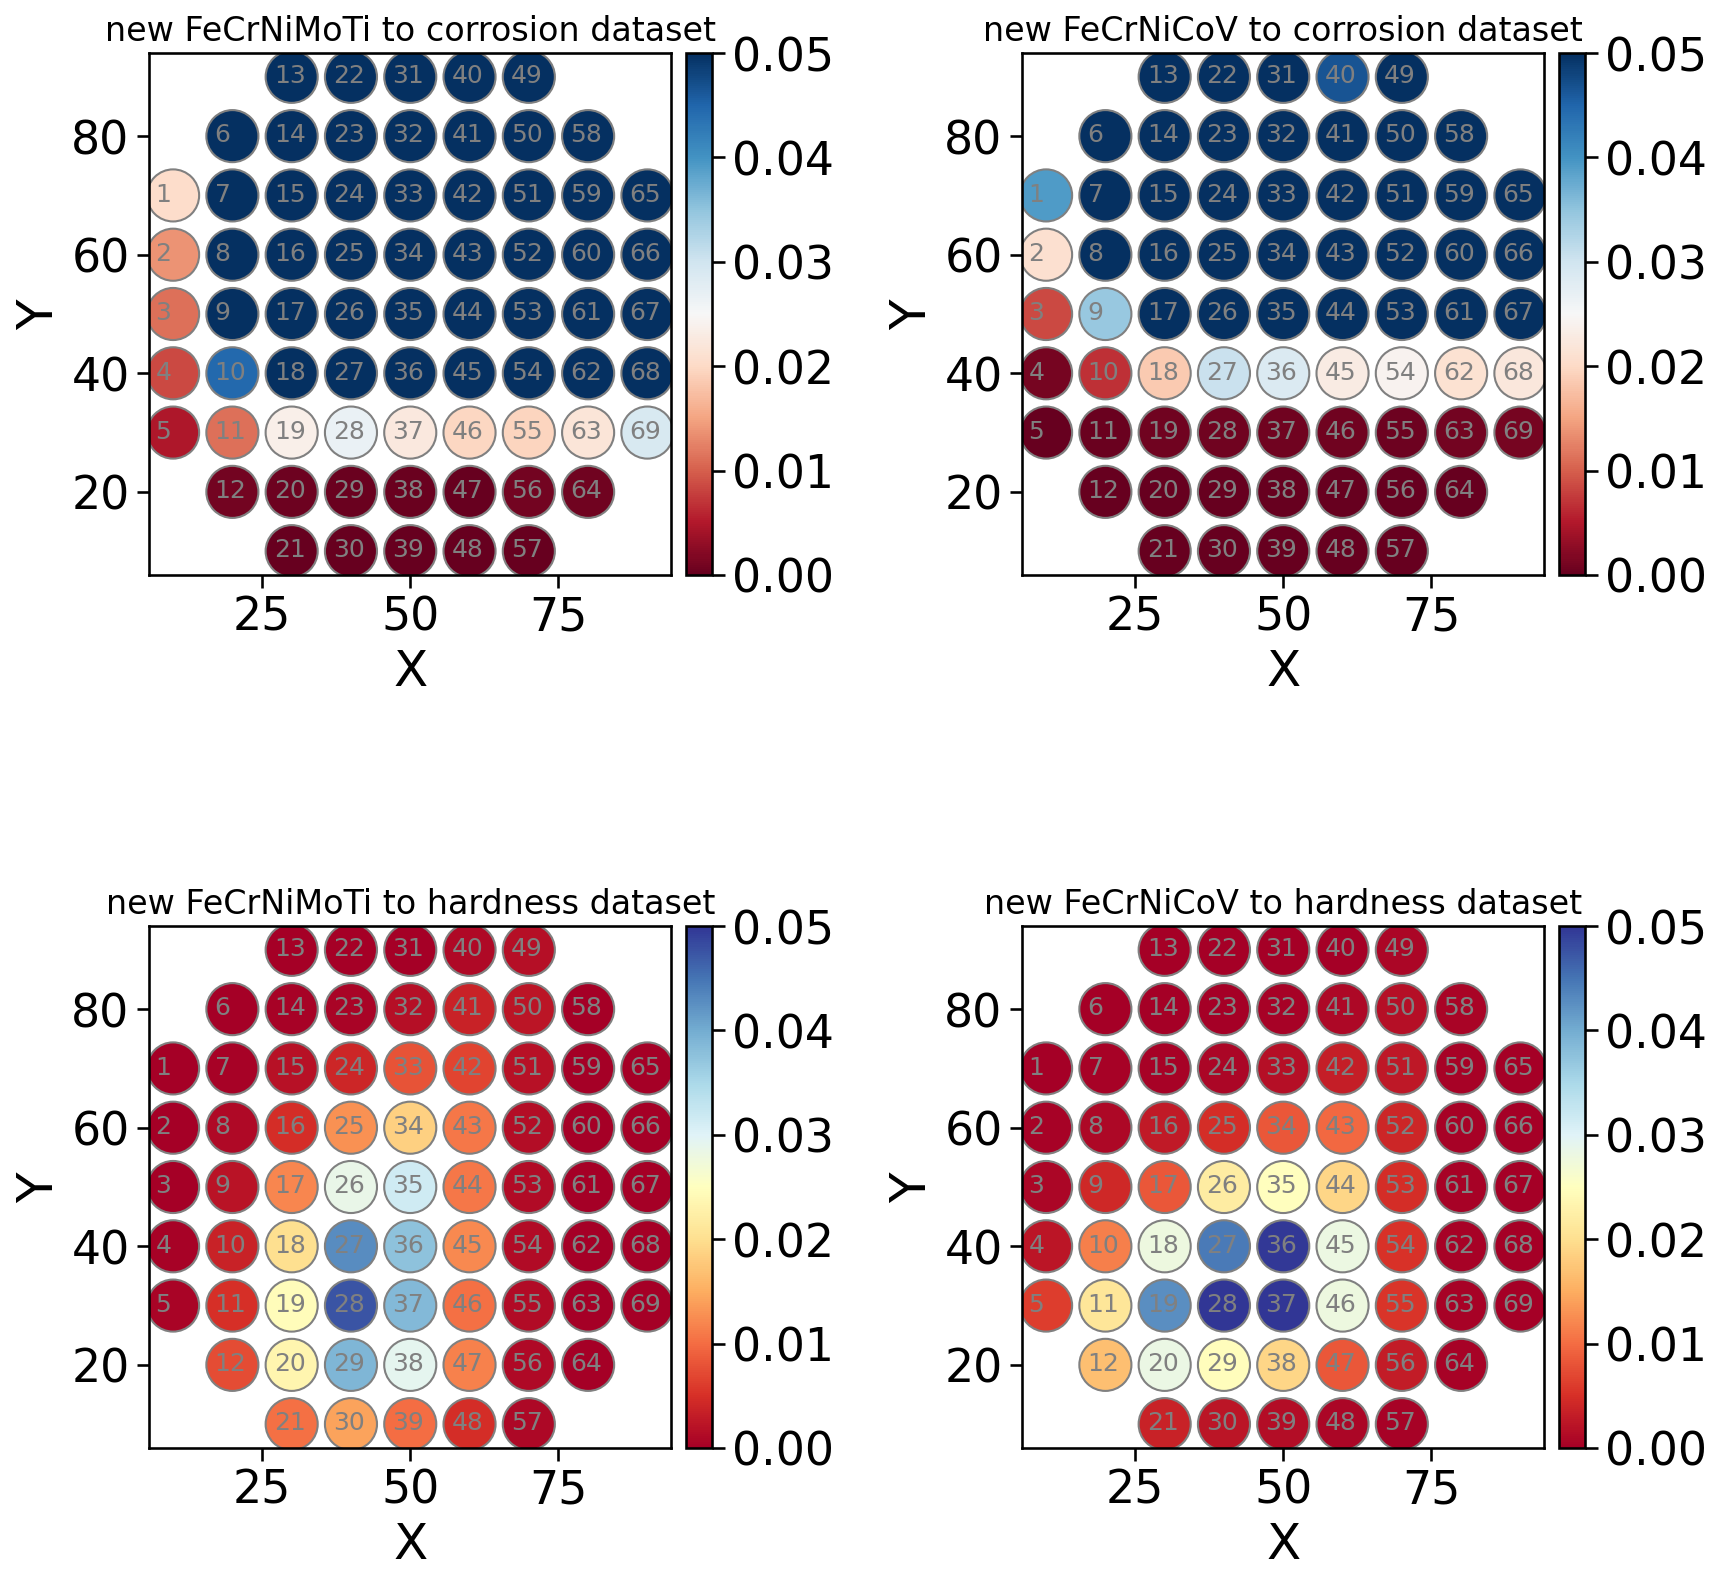

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')

def create_PVD_scatter(df, PVD_x_y, dataset_values, ax, cmap="RdBu", title=""):
    # Create dataframe for the new dataset
    df_new = df[df["dataset"] == dataset_values[1]]

    # Create the scatter plot
    scatter_alpha = 1
    scatter_size = 2500
    scatter = ax.scatter(PVD_x_y["x"], PVD_x_y["y"], c=df_new["p value"], cmap=cmap, edgecolor="grey", 
                         s=scatter_size, marker='.', alpha=scatter_alpha, vmin=0, vmax=0.05)

    for i, txt in enumerate(PVD_x_y.index+1):
        ax.annotate(txt, (PVD_x_y["x"].iloc[i]-3, PVD_x_y["y"].iloc[i]-1), color="grey", alpha=1, fontsize=12)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title, fontsize=16)
    ax.set_aspect('equal', 'box')
    
    # export the df_new to excel using the name of title
    df_new.to_excel(title + ".xlsx")
 
    return scatter

fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=150)

datasets = [(df_C_new_FeCrNiMoTi_Mahl_label, [0, 2], "RdBu", "new FeCrNiMoTi to corrosion dataset"),
            (df_C_new_FeCrNiCoV_Mahl_label, [0, 3], "RdBu", "new FeCrNiCoV to corrosion dataset"),
            (df_H_new_FeCrNiMoTi_Mahl_label, [1, 2], "RdYlBu", "new FeCrNiMoTi to hardness dataset"),
            (df_H_new_FeCrNiCoV_Mahl_label, [1, 3], "RdYlBu", "new FeCrNiCoV to hardness dataset")]

for i, (df, dataset_values, cmap, title) in enumerate(datasets):
    axi = ax[i//2, i%2]
    scatter = create_PVD_scatter(df, PVD_x_y, dataset_values, axi, cmap=cmap, title=title)

    divider = make_axes_locatable(axi)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(scatter, cax=cax)

plt.tight_layout()
plt.savefig('PVD 2D_Mahalanobis.png')
plt.show()


other possibilities: I will also fix the level of color contours: because maybe the rational way here when selecting compositions is selecting a few ranges: close->intermediate->far from the center of the data group


In [17]:
 
z_C_new_FeCrNiMoTi_Mahl_label = df_C_new_FeCrNiMoTi_Mahl_label[df_C_new_FeCrNiMoTi_Mahl_label["dataset"] == 2]["p value"].to_numpy()

print(z_C_new_FeCrNiMoTi_Mahl_label)


[2.04106096e-02 1.38339637e-02 1.11792973e-02 8.44678808e-03
 4.77074110e-03 1.21022016e-01 1.07547908e-01 8.68446923e-02
 7.19019583e-02 4.46180908e-02 1.12286465e-02 9.35977327e-04
 1.35690339e-01 1.92700309e-01 2.48063671e-01 2.28527315e-01
 2.05097543e-01 9.51431599e-02 2.36209198e-02 5.36409858e-04
 9.18167702e-08 1.25675900e-01 1.94689420e-01 2.79591999e-01
 3.28760459e-01 3.03744823e-01 1.40436713e-01 2.66149089e-02
 3.24238165e-04 5.23261123e-09 1.01694120e-01 1.72152853e-01
 2.54105421e-01 2.97216032e-01 2.74531258e-01 1.41682817e-01
 2.22975156e-02 2.64793349e-04 1.20801935e-09 9.54923818e-02
 1.45524280e-01 1.92181203e-01 2.53278478e-01 2.47084112e-01
 1.32416010e-01 1.95670692e-02 1.49084523e-04 2.12827089e-08
 8.20456777e-02 1.22602425e-01 1.49621576e-01 1.74951729e-01
 1.66025971e-01 1.05149906e-01 1.94330034e-02 8.45994977e-04
 1.45069805e-08 9.19429617e-02 1.01266623e-01 1.22526280e-01
 1.21780626e-01 9.26428833e-02 2.18395906e-02 6.67596908e-04
 7.44865823e-02 7.914263

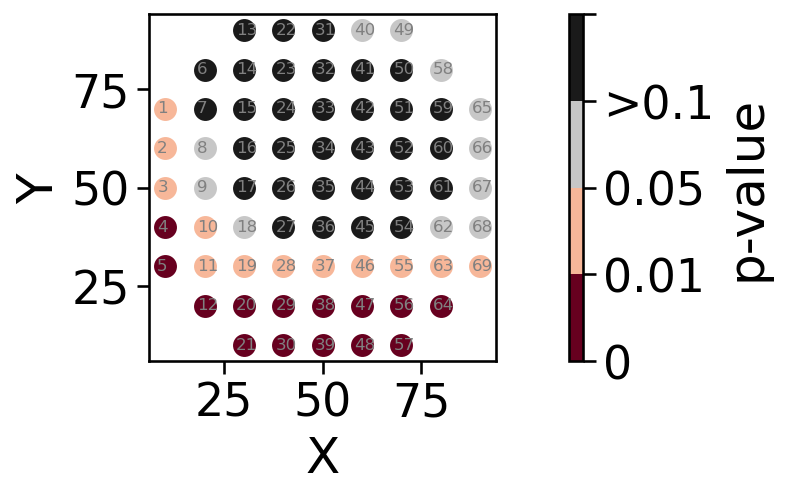

In [18]:

fig, (ax1, ax2) = plt.subplots(figsize = (4, 3),
                          ncols = 2, gridspec_kw={'width_ratios': [3, 0.1]}, dpi=150)

# plot the fixed intervals 
cmap = cm.RdGy(np.linspace(0, 1, 4))  # RdBu/RdGy
 
c_0_01     = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.01]
c_0_05    = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.05 and v >= 0.01]
c_0_1     = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.1  and v >= 0.05]
c_abv_0_1 = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if              v >= 0.1]

cax1 = ax1.scatter(PVD_x_y["x"][c_0_01],    PVD_x_y["y"][c_0_01],    color=cmap[0], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax2 = ax1.scatter(PVD_x_y["x"][c_0_05],    PVD_x_y["y"][c_0_05],    color=cmap[1], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax3 = ax1.scatter(PVD_x_y["x"][c_0_1],     PVD_x_y["y"][c_0_1],     color=cmap[2], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax4 = ax1.scatter(PVD_x_y["x"][c_abv_0_1], PVD_x_y["y"][c_abv_0_1], color=cmap[3], s=400, marker='.') # ,vmin=0.2, vmax=0.6

ax1.set_aspect('equal', 'box')
for i, txt in enumerate(PVD_x_y.index+1):
    ax1.annotate(txt, (PVD_x_y["x"][i]-2, PVD_x_y["y"][i]-1), color="grey", alpha=1, fontsize=8)
 
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_title(KW_name+'_'+PT_name) 


# customised colorbar: https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

cmap = mpl.cm.RdGy  #RdBu/RdGy
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='vertical',  
             label="p-value")
cbar.ax.set_yticklabels(['0','0.01','0.05','>0.1',''])

plt.show()